# Model Selection 

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = Data().load('data/hospital_dataset')
variables = data.get_variables_dict()
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [4]:
variables['categorical_variables'].extend(['date_weekday','admission_weekday','date_month','admission_month'])

In [5]:
date_variables = ['date_weekday','admission_weekday','date_month','admission_month']

In [6]:
categorical_variables = ['images_requester_roles',
 'images_study_types',
 'labos_requester_roles',
 'sectors_last_sector',
 'sectors_names',
 'surgeries_actual',
 'surgeries_anesthesia_types',
 'surgeries_bact_positive',
 'surgeries_injury_condition',
 'surgeries_post_surgery_condition',
 'surgeries_scheduled',
 'surgeries_scheduled_done',
 'surgeries_services',
 'surgeries_types',
 'gender',
 'insurance_entity',
 'entity_group',
 'origin',
 'admission_sector',
 'isolation',
 'presumptive_dianogsis',
 'responsible_sector',
 'ARM_TEP',
 'CEC_TEP',
 'request_origin',
 'request',
 'request_diagnosis',
 'request_sector',
 'date_weekday',
 'admission_weekday',
 'date_month',
 'admission_month']

In [7]:
numerical_variables = ['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [8]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : ['date_weekday','admission_weekday','date_month','admission_month']
                #'numerical_features' : variables['numerical_variables']
               }

In [9]:
lgbm_dateonly_features = Model(**model_params)
lgbm_dateonly_features.transform(data)

Fitting pipeline...
Transforming data...


### Date only

In [10]:
%%time
import time
start = time.time()
lgbm_dateonly_features.fit_classifier()
end = time.time()

Training classifier
[10]	training_set's auc: 0.618082	validation_set's auc: 0.611594
[20]	training_set's auc: 0.620919	validation_set's auc: 0.611646
[30]	training_set's auc: 0.623593	validation_set's auc: 0.612449
[40]	training_set's auc: 0.625018	validation_set's auc: 0.612795
[50]	training_set's auc: 0.626128	validation_set's auc: 0.612841
[60]	training_set's auc: 0.626859	validation_set's auc: 0.613099
[70]	training_set's auc: 0.62751	validation_set's auc: 0.61338
[80]	training_set's auc: 0.628039	validation_set's auc: 0.613451
[90]	training_set's auc: 0.628294	validation_set's auc: 0.613268
[100]	training_set's auc: 0.628606	validation_set's auc: 0.613113
CPU times: user 7.17 s, sys: 251 ms, total: 7.42 s
Wall time: 5.71 s


In [11]:
lgbm_dateonly_features.n_features

33

In [12]:
perf = lgbm_dateonly_features.get_performance_metrics()

training AUC ROC score:  0.6286063439277708
validation AUC ROC score:  0.6131131292795517
relative over-fitting:  0.0246469269645158


In [13]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([3, 
                 'date_features_only', 
                 'gdbt', 
                 lgbm_dateonly_features.n_features,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

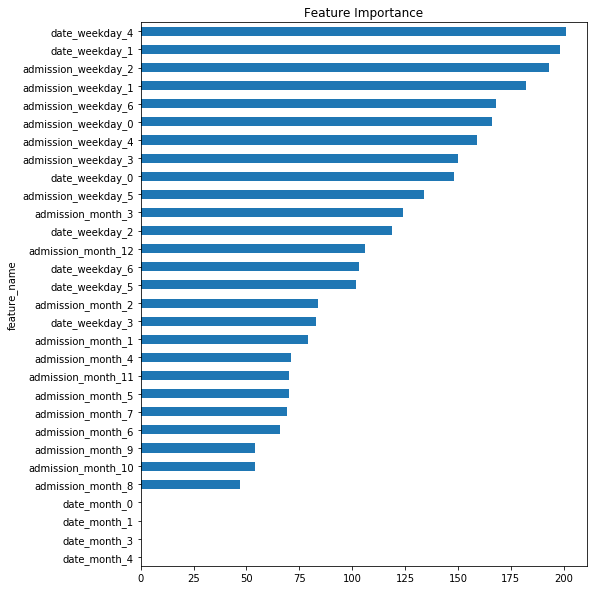

In [14]:
lgbm_dateonly_features.plot_feature_importance()

### Date + Extrafeatures

#### Baseline

In [15]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : categorical_variables,
                'numerical_features' : numerical_variables
               }

In [16]:
len(categorical_variables)+len(numerical_variables)

63

In [17]:
lgbm_date_features = Model(**model_params)
lgbm_date_features.transform(data)

Fitting pipeline...
Transforming data...


In [18]:
%%time
start = time.time()
lgbm_date_features.fit_classifier()
end = time.time()

Training classifier
[10]	training_set's auc: 0.83213	validation_set's auc: 0.823267
[20]	training_set's auc: 0.840217	validation_set's auc: 0.83008
[30]	training_set's auc: 0.845044	validation_set's auc: 0.834088
[40]	training_set's auc: 0.849027	validation_set's auc: 0.837263
[50]	training_set's auc: 0.851814	validation_set's auc: 0.83895
[60]	training_set's auc: 0.853875	validation_set's auc: 0.840321
[70]	training_set's auc: 0.855651	validation_set's auc: 0.841519
[80]	training_set's auc: 0.856752	validation_set's auc: 0.842109
[90]	training_set's auc: 0.858021	validation_set's auc: 0.842655
[100]	training_set's auc: 0.859094	validation_set's auc: 0.843203
CPU times: user 42.9 s, sys: 325 ms, total: 43.2 s
Wall time: 11.9 s


In [19]:
perf = lgbm_date_features.get_performance_metrics()

training AUC ROC score:  0.8590941924724197
validation AUC ROC score:  0.8432030596569273
relative over-fitting:  0.018497544221267145


In [19]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([3, 
                 'date+extra_features', 
                 'gdbt', 
                 lgbm_date_features.n_features,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

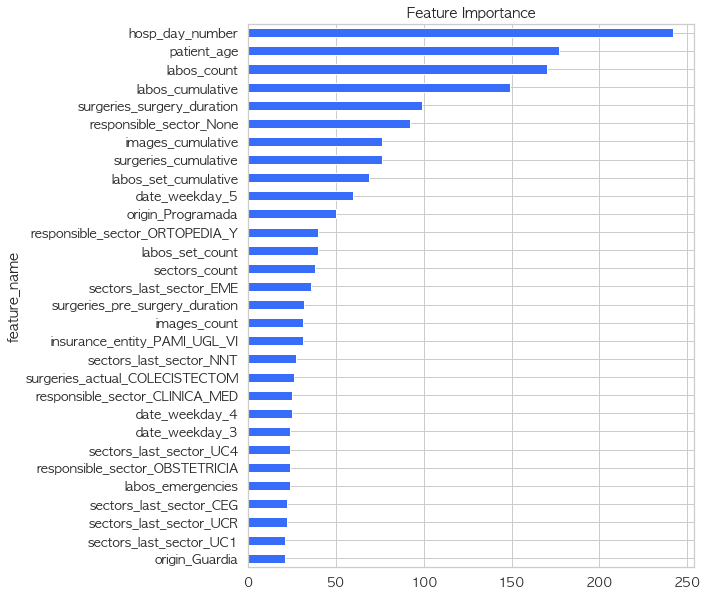

In [20]:
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
lgbm_date_features.plot_feature_importance()

### Random Forest

In [21]:
model_params = {'classifier': 'random_forest',
               'accepts_sparse': True,
                'categorical_features' : categorical_variables,
                'numerical_features' : numerical_variables
               }

In [22]:
rf_date_features = Model(**model_params)
rf_date_features.transform(data)

Fitting pipeline...
Transforming data...


In [23]:
%%time
start = time.time()
rf_date_features.fit_classifier()
end = time.time()


Training classifier
[10]	training_set's auc: 0.810018	validation_set's auc: 0.803061
[20]	training_set's auc: 0.810587	validation_set's auc: 0.80358
[30]	training_set's auc: 0.810507	validation_set's auc: 0.803578
[40]	training_set's auc: 0.810357	validation_set's auc: 0.803375
[50]	training_set's auc: 0.810709	validation_set's auc: 0.803746
[60]	training_set's auc: 0.810853	validation_set's auc: 0.804263
[70]	training_set's auc: 0.811196	validation_set's auc: 0.804425
[80]	training_set's auc: 0.811152	validation_set's auc: 0.804437
[90]	training_set's auc: 0.81106	validation_set's auc: 0.804302
[100]	training_set's auc: 0.811103	validation_set's auc: 0.804293
CPU times: user 45 s, sys: 433 ms, total: 45.4 s
Wall time: 13.1 s


In [24]:
perf = rf_date_features.get_performance_metrics()

training AUC ROC score:  0.8111031508452098
validation AUC ROC score:  0.8042927051656623
relative over-fitting:  0.008396522282585944


In [26]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([3, 
                 'date+extra_features', 
                 'rf', 
                 rf_date_features.n_features,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

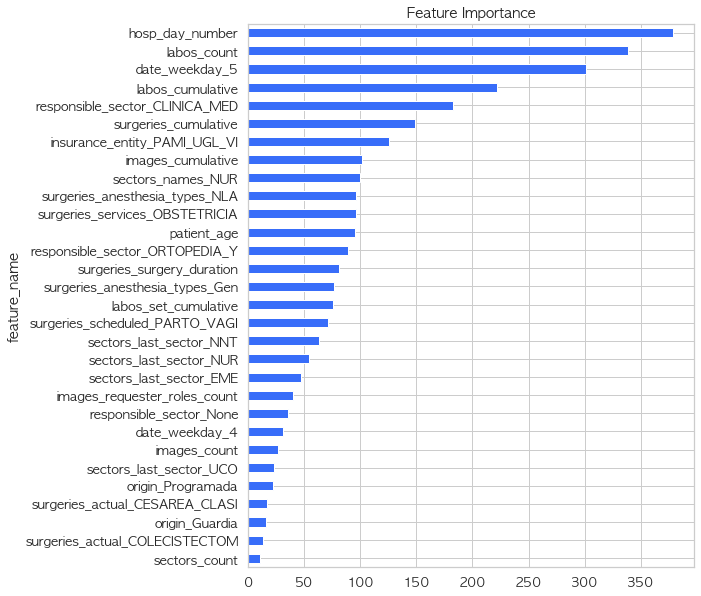

In [25]:
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
rf_date_features.plot_feature_importance()